# Airline customer satisfaction analysis

Imported libraries

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain
import seaborn as sns


import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold,cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, plot_confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, precision_recall_fscore_support
from scipy import stats

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

import os

%matplotlib inline 

## Loading the data and visualizing it

In [2]:
directory = "./dataset/"
feature_tables = ['train.csv', 'test.csv']

df_train = directory + feature_tables[0]
df_test = directory + feature_tables[1]

# Create dataframes
print(f'Reading csv from {df_train}...')
train = pd.read_csv(df_train)
print('...Complete')

print(f'Reading csv from {df_train}...')
test = pd.read_csv(df_test)
print('...Complete')

Reading csv from ./dataset/train.csv...
...Complete
Reading csv from ./dataset/train.csv...
...Complete


The dataset is given in two sets: train and test. We are concatenating them so we can implement our own techniques of validation

In [3]:
#Concatenating the two datasets

datasets = [train, test]
df_dataset = pd.concat(datasets)

In [4]:
df_dataset.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [5]:
# Retrieving some information about the dataset

df_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129880 entries, 0 to 25975
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         129880 non-null  int64  
 1   id                                 129880 non-null  int64  
 2   Gender                             129880 non-null  object 
 3   Customer Type                      129880 non-null  object 
 4   Age                                129880 non-null  int64  
 5   Type of Travel                     129880 non-null  object 
 6   Class                              129880 non-null  object 
 7   Flight Distance                    129880 non-null  int64  
 8   Inflight wifi service              129880 non-null  int64  
 9   Departure/Arrival time convenient  129880 non-null  int64  
 10  Ease of Online booking             129880 non-null  int64  
 11  Gate location                      12988

## Data cleansing

From the ```info``` we can see: 

1. There are  columns in which the data should be categorical and needs to be converted;

2. We can also see that the dataset has some missing data and it needs to be cleaned;

3. We need to drop the first two columns, irrelevant for the problem (id columns).

In [6]:
def transform_gender(x):
    if x == 'Female':
        return 1
    elif x == 'Male':
        return 0
    else:
        return -1
    
def transform_customer_type(x):
    if x == 'Loyal Customer':
        return 1
    elif x == 'disloyal Customer':
        return 0
    else:
        return -1
    
def transform_travel_type(x):
    if x == 'Business travel':
        return 1
    elif x == 'Personal Travel':
        return 0
    else:
        return -1
    
def transform_class(x):
    if x == 'Business':
        return 2
    elif x == 'Eco Plus':
        return 1
    elif x == 'Eco':
        return 0    
    else:
        return -1
    
def transform_satisfaction(x):
    if x == 'satisfied':
        return 1
    elif x == 'neutral or dissatisfied':
        return 0
    else:
        return -1
    
def process_data(df):
    df = df.drop(['Unnamed: 0', 'id'], axis = 1)
    df['Gender'] = df['Gender'].apply(transform_gender)
    df['Customer Type'] = df['Customer Type'].apply(transform_customer_type)
    df['Type of Travel'] = df['Type of Travel'].apply(transform_travel_type)
    df['Class'] = df['Class'].apply(transform_class)
    df['satisfaction'] = df['satisfaction'].apply(transform_satisfaction)
    df['Arrival Delay in Minutes'].fillna(df['Arrival Delay in Minutes'].median(), inplace = True)
    return df


df_dataset.dropna(inplace=True)
data = process_data(df_dataset)

## Overviewing the data

We can get information about the data using the ``desbribe`` method for both quantitative and categorical values.

In [7]:
data.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,1,13,0,1,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,0
1,0,0,25,1,2,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,0
2,1,1,26,1,2,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,1
3,1,1,25,1,2,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,0
4,0,1,61,1,2,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,1


In [8]:
data.describe()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
count,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,...,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000
mean,0.507410,0.816862,39.428761,0.690764,1.029910,1190.210662,2.728544,3.057349,2.756786,2.976909,...,3.358067,3.383204,3.351078,3.631886,3.306239,3.642373,3.286222,14.643385,15.091129,0.434499
std,0.499947,0.386781,15.117597,0.462180,0.962638,997.560954,1.329235,1.526787,1.401662,1.278506,...,1.334149,1.287032,1.316132,1.180082,1.266146,1.176614,1.313624,37.932867,38.465650,0.495693
min,0.000000,0.000000,7.000000,0.000000,0.000000,31.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,27.000000,0.000000,0.000000,414.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,40.000000,1.000000,1.000000,844.000000,3.000000,3.000000,3.000000,3.000000,...,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,51.000000,1.000000,2.000000,1744.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000,1.000000
max,1.000000,1.000000,85.000000,1.000000,2.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000,1.000000


We can check the distribution of customer's satisfaction within the data  

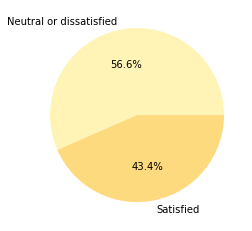

In [9]:
plt.pie(data.satisfaction.value_counts(),
        labels = ["Neutral or dissatisfied",
        "Satisfied"],
        colors = sns.color_palette("YlOrBr"),
        autopct = '%1.1f%%')
pass

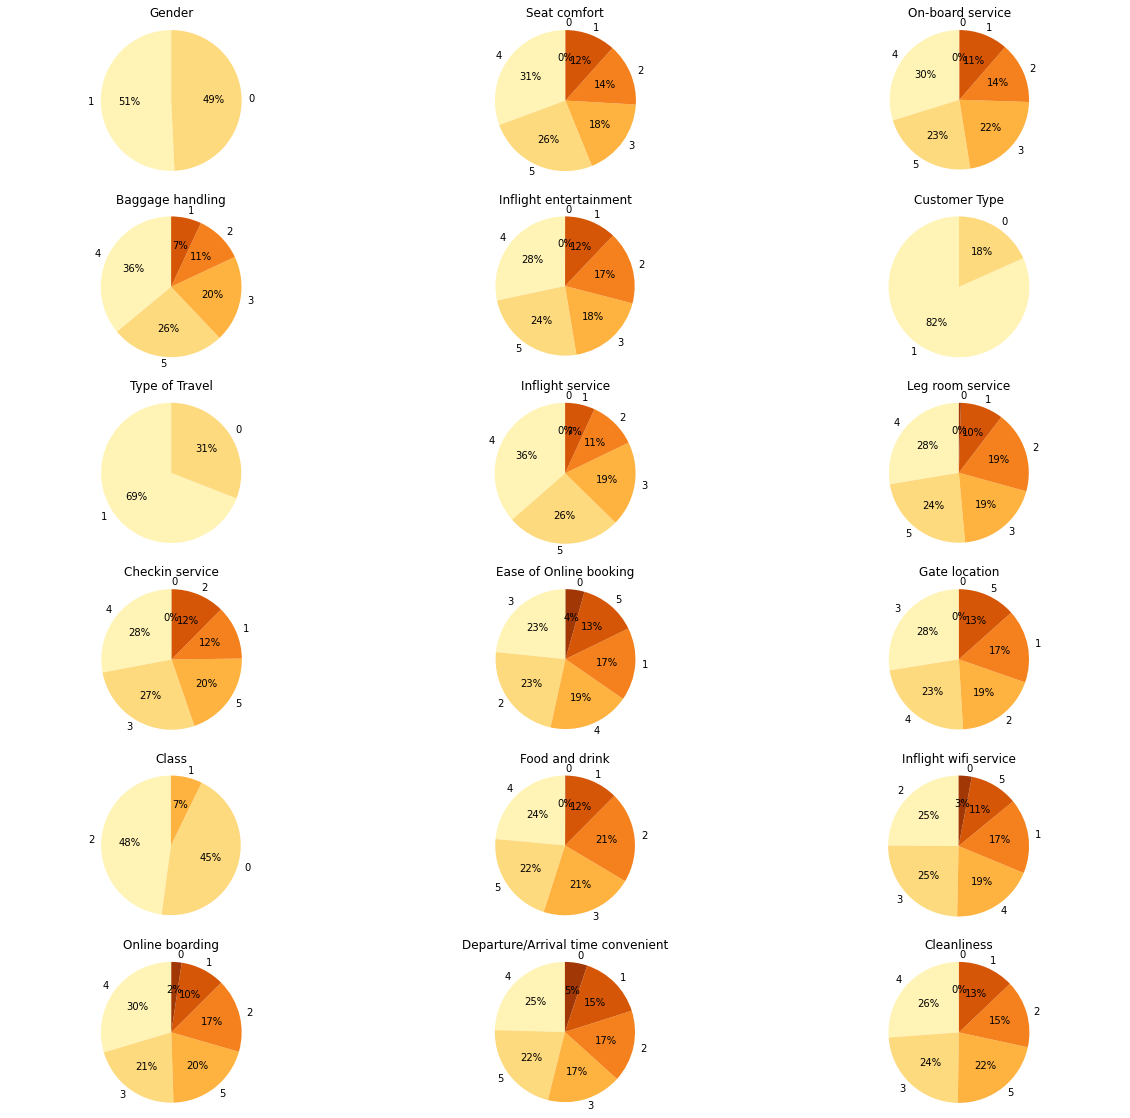

In [10]:
# Retrieving categorical indexes

numerical_columns = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
categorical_columns = set(data.columns) ^ set(numerical_columns)
categorical_columns.remove('satisfaction')

fig, axes = plt.subplots(6, 3, figsize = (20, 20))

for i, col in enumerate(categorical_columns):
    column_values = data[col].value_counts()
    labels = column_values.index
    sizes = column_values.values
    # axes[i//3, i%3].barh(y =sizes, width = 0.5, color = sns.color_palette("YlOrBr"))
    axes[i//3, i%3].pie(sizes, labels = labels, colors = sns.color_palette("YlOrBr"), autopct = '%1.0f%%', startangle = 90)
    axes[i//3, i%3].axis('equal')
    axes[i//3, i%3].set_title(col)
plt.show()

```
From these graphs we can see that:
- The dataset is balanced between genders : women and men
- There are far more answers from loyal customers than from disloyal
- The majority of travels are 'Business travels'
- And most of the evaluations have the ``0 score`` being less than 5% 
```

We can also check for the correlation between the features

C:\Users\HPJOAO~1\AppData\Local\Temp/ipykernel_27756/1711578135.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

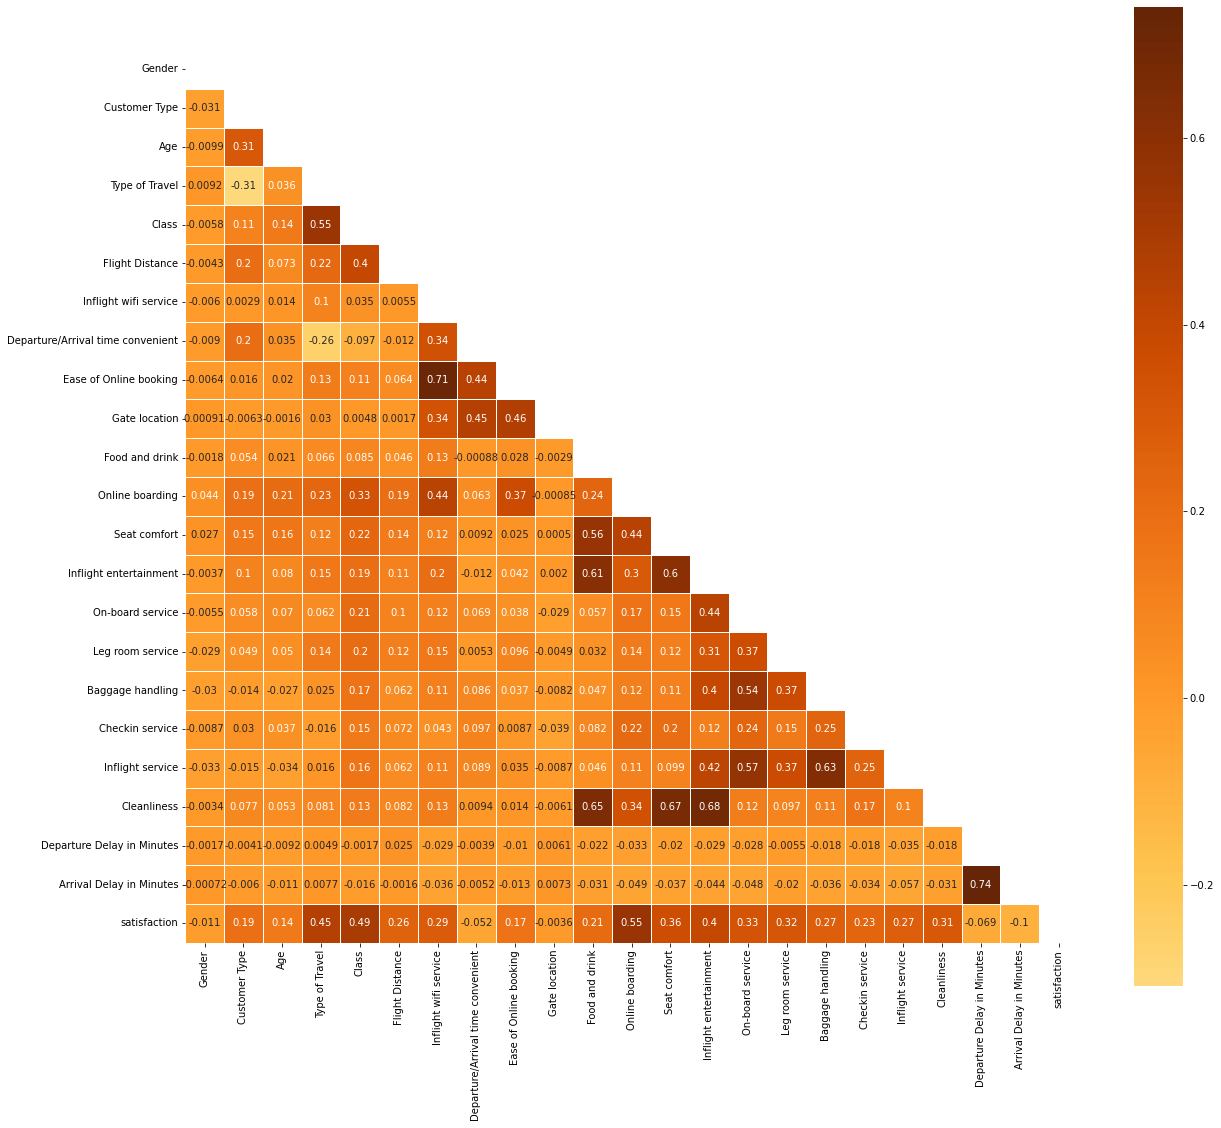

In [11]:
corr = data.corr(method='spearman')
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 18))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot = True, mask=mask, cmap="YlOrBr", center=0,
            square=True, linewidths=.5)

### Creating a K-fold for cross validation

In [12]:
X = data.iloc[:, 0:-1].values
y = data.iloc[:, -1].values
scaler = StandardScaler()

skf = StratifiedKFold(n_splits=4,random_state=42, shuffle=True)

skf.get_n_splits(X,y)


print(skf)
for train_index, test_index in skf.split(X,y):
    X[train_index] = scaler.fit_transform(X[train_index])
    X[test_index]= scaler.fit_transform(X[test_index])

StratifiedKFold(n_splits=4, random_state=42, shuffle=True)


## Models Evaluation

Once the data is ready, we can now train different models and compare the results to see which one fits the problem the best.

We'll be looking at the ROC_AUC metric, as well as the confusion matrix and the metric extracted from it, such as precision and recall.

At the end, we'll rank the models by accuracy.

In [13]:
def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_pred)
    report = precision_recall_fscore_support(y_test,y_pred)
    print("ROC_AUC = {}".format(roc_auc))
    print(classification_report(y_test,y_pred,digits=5,target_names=["Neutral/Dissatisfied","Satisfied"]))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=model.classes_,display_labels=["Neutral/Dissatisfied","Satisfied"], normalize='all',cmap='YlOrBr')
    plt.show()
    return model, roc_auc, report

### Gaussian Naive Bayes

------------------ Results 1 fold --------------------
ROC_AUC = 0.8606414133041679
                      precision    recall  f1-score   support

Neutral/Dissatisfied    0.86869   0.89796   0.88308     18307
           Satisfied    0.86109   0.82332   0.84178     14065

            accuracy                        0.86553     32372
           macro avg    0.86489   0.86064   0.86243     32372
        weighted avg    0.86539   0.86553   0.86514     32372



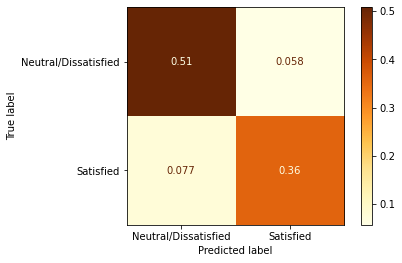

------------------ Results 2 fold --------------------
ROC_AUC = 0.8578457344781043
                      precision    recall  f1-score   support

Neutral/Dissatisfied    0.86583   0.89648   0.88089     18306
           Satisfied    0.85877   0.81921   0.83852     14066

            accuracy                        0.86291     32372
           macro avg    0.86230   0.85785   0.85971     32372
        weighted avg    0.86276   0.86291   0.86248     32372



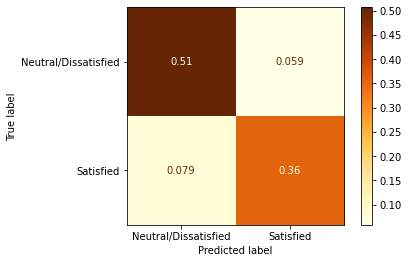

------------------ Results 3 fold --------------------
ROC_AUC = 0.8575617530560032
                      precision    recall  f1-score   support

Neutral/Dissatisfied    0.86583   0.89577   0.88055     18306
           Satisfied    0.85796   0.81935   0.83821     14066

            accuracy                        0.86257     32372
           macro avg    0.86190   0.85756   0.85938     32372
        weighted avg    0.86241   0.86257   0.86215     32372



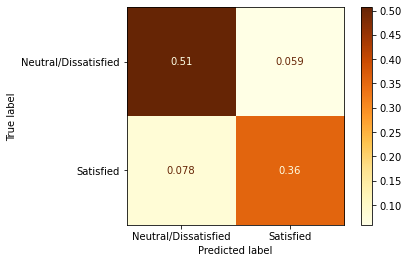

------------------ Results 4 fold --------------------
ROC_AUC = 0.8606347676651795
                      precision    recall  f1-score   support

Neutral/Dissatisfied    0.86769   0.89987   0.88348     18306
           Satisfied    0.86307   0.82140   0.84172     14065

            accuracy                        0.86577     32371
           macro avg    0.86538   0.86063   0.86260     32371
        weighted avg    0.86568   0.86577   0.86534     32371



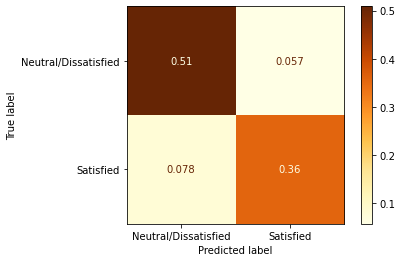

------------------ Mean Results --------------------
Mean precision: 0.8636162215139498
---
Mean recall: 0.8591709171258638
---
Mean f-scores: 0.861030299918703
---
Mean ROC_AUC: 0.8591709171258638


In [14]:
params_gnb = {}

precisions_gnb = []
recalls_gnb = []
f_scores_gnb = []
supports_gnb = []
rocs_auc_gnb = []
index = 0

for train_index, test_index in skf.split(X,y):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    index+=1

    print(f"------------------ Results {index} fold --------------------")
    model_gnb = GaussianNB(**params_gnb)
    model_gnb, roc_auc_gnb,report_gnb = run_model(model_gnb, X_train, y_train, X_test, y_test)
    precision, recall, f_score, support = report_gnb
    precisions_gnb.append(precision)
    recalls_gnb.append(recall)
    f_scores_gnb.append(f_score)
    supports_gnb.append(support)
    rocs_auc_gnb.append(roc_auc_gnb)
print("------------------ Mean Results --------------------")
print(f"Mean precision: {np.mean((precisions_gnb))}\n---")
print(f"Mean recall: {np.mean((recalls_gnb))}\n---")
print(f"Mean f-scores: {np.mean((f_scores_gnb))}\n---")
print(f"Mean ROC_AUC: {np.mean((rocs_auc_gnb))}")
  

#### Plotting the ROC curve to analyse the influence of the stratified cross-validation

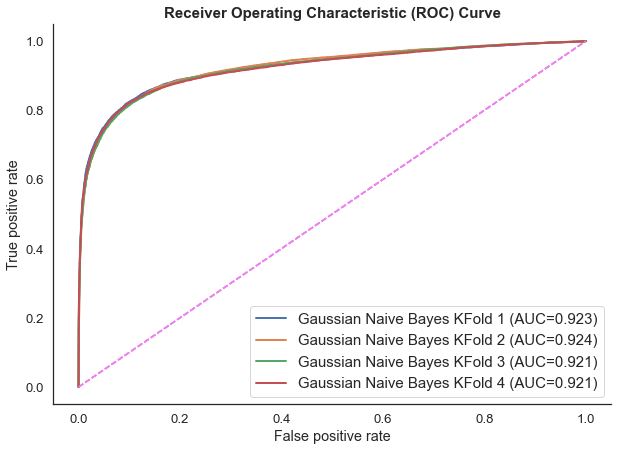

In [15]:
fig = plt.figure(figsize=[10,7])
i = 0
for train_index, test_index in skf.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    fpr, tpr, thresholds = roc_curve(y_test, model_gnb.predict_proba(X_test)[:,1])
    sns.set(style='white',font_scale=1.2)
    plt.plot(fpr, tpr,lw=2,label='Gaussian Naive Bayes KFold {:d} (AUC={:.3f})'.format(i+1, roc_auc_score(y_test, model_gnb.predict_proba(X_test)[:,1])))
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.legend(loc="lower right",fontsize=15)

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve',weight='bold',fontsize=15);
    sns.despine()
    plt.savefig('ROCplot.png',transparent=True, bbox_inches='tight')
    i += 1

### KNN

------------------ Results 1 fold --------------------
ROC_AUC = 0.9222795994476712
                      precision    recall  f1-score   support

Neutral/Dissatisfied    0.91655   0.95810   0.93687     18307
           Satisfied    0.94205   0.88646   0.91341     14065

            accuracy                        0.92697     32372
           macro avg    0.92930   0.92228   0.92514     32372
        weighted avg    0.92763   0.92697   0.92667     32372



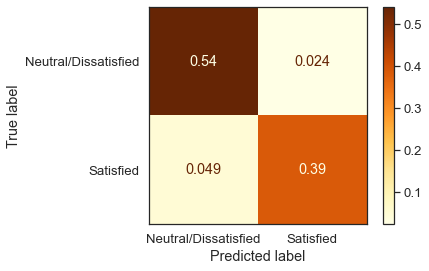

------------------ Results 2 fold --------------------
ROC_AUC = 0.9222630187984414
                      precision    recall  f1-score   support

Neutral/Dissatisfied    0.91616   0.95870   0.93695     18306
           Satisfied    0.94280   0.88582   0.91342     14066

            accuracy                        0.92704     32372
           macro avg    0.92948   0.92226   0.92519     32372
        weighted avg    0.92774   0.92704   0.92673     32372



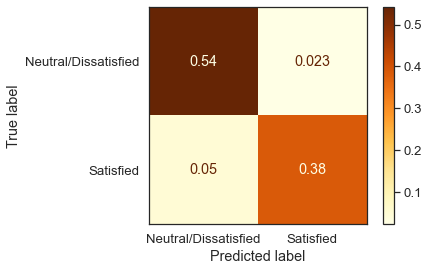

------------------ Results 3 fold --------------------
ROC_AUC = 0.9205740278047106
                      precision    recall  f1-score   support

Neutral/Dissatisfied    0.91480   0.95717   0.93550     18306
           Satisfied    0.94069   0.88398   0.91145     14066

            accuracy                        0.92537     32372
           macro avg    0.92774   0.92057   0.92348     32372
        weighted avg    0.92605   0.92537   0.92505     32372



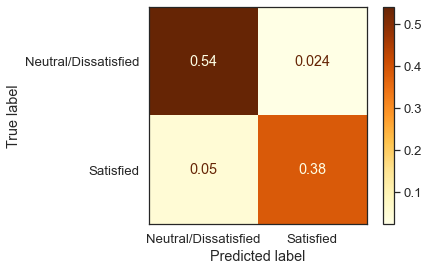

------------------ Results 4 fold --------------------
ROC_AUC = 0.9195797368036036
                      precision    recall  f1-score   support

Neutral/Dissatisfied    0.91321   0.95761   0.93488     18306
           Satisfied    0.94110   0.88155   0.91035     14065

            accuracy                        0.92456     32371
           macro avg    0.92716   0.91958   0.92262     32371
        weighted avg    0.92533   0.92456   0.92422     32371



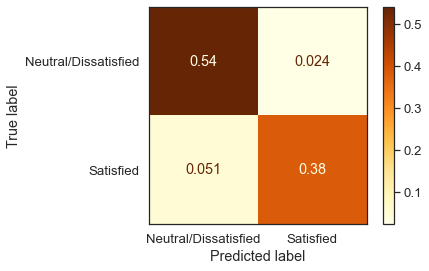

------------------ Mean Results --------------------
Mean precision: 0.9284187255819185
---
Mean recall:0.9211740957136068
---
Mean f-scores: 0.9241043615705332
---
Mean ROC_AUC: 0.9211740957136068


In [16]:
params_kn = {'n_neighbors': 3,
             'metric':'minkowski',
             'p':2}

precisions_knn = []
recalls_knn = []
f_scores_knn = []
supports_knn = []
rocs_auc_knn = []
index = 0

for train_index, test_index in skf.split(X,y):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    index+=1

    print(f"------------------ Results {index} fold --------------------")

    model_kn = KNeighborsClassifier(**params_kn)
    model_kn, roc_auc_knn, report_knn = run_model(model_kn, X_train, y_train, X_test, y_test)

    precision, recall, f_score, support = report_knn
    precisions_knn.append(precision)
    recalls_knn.append(recall)
    f_scores_knn.append(f_score)
    supports_knn.append(support)
    rocs_auc_knn.append(roc_auc_knn)
    
print("------------------ Mean Results --------------------")
print(f"Mean precision: {np.mean((precisions_knn))}\n---")
print(f"Mean recall:{np.mean((recalls_knn))}\n---")
print(f"Mean f-scores: {np.mean((f_scores_knn))}\n---")
print(f"Mean ROC_AUC: {np.mean((rocs_auc_knn))}")

### Decision Tree

------------------ Results 1 fold --------------------
ROC_AUC = 0.949106250426355
                      precision    recall  f1-score   support

Neutral/Dissatisfied    0.95187   0.96149   0.95666     18307
           Satisfied    0.94921   0.93672   0.94292     14065

            accuracy                        0.95073     32372
           macro avg    0.95054   0.94911   0.94979     32372
        weighted avg    0.95071   0.95073   0.95069     32372



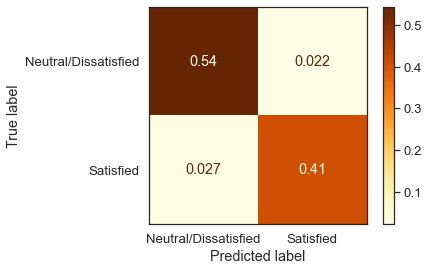

------------------ Results 2 fold --------------------
ROC_AUC = 0.9459824755232583
                      precision    recall  f1-score   support

Neutral/Dissatisfied    0.95118   0.95581   0.95349     18306
           Satisfied    0.94212   0.93616   0.93913     14066

            accuracy                        0.94727     32372
           macro avg    0.94665   0.94598   0.94631     32372
        weighted avg    0.94724   0.94727   0.94725     32372



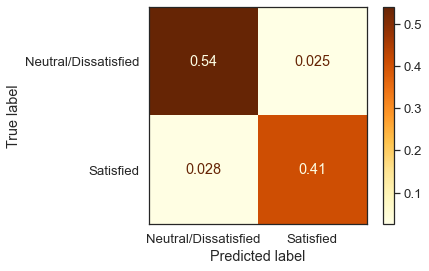

------------------ Results 3 fold --------------------
ROC_AUC = 0.9481806198118718
                      precision    recall  f1-score   support

Neutral/Dissatisfied    0.95068   0.96127   0.95594     18306
           Satisfied    0.94885   0.93509   0.94192     14066

            accuracy                        0.94989     32372
           macro avg    0.94976   0.94818   0.94893     32372
        weighted avg    0.94988   0.94989   0.94985     32372



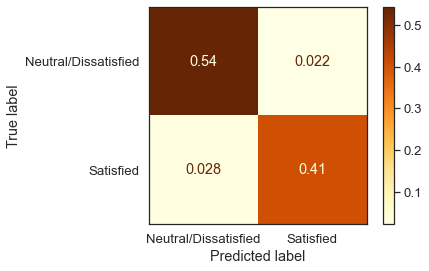

------------------ Results 4 fold --------------------
ROC_AUC = 0.9483641933556837
                      precision    recall  f1-score   support

Neutral/Dissatisfied    0.95403   0.95674   0.95538     18306
           Satisfied    0.94348   0.93999   0.94173     14065

            accuracy                        0.94946     32371
           macro avg    0.94875   0.94836   0.94856     32371
        weighted avg    0.94944   0.94946   0.94945     32371



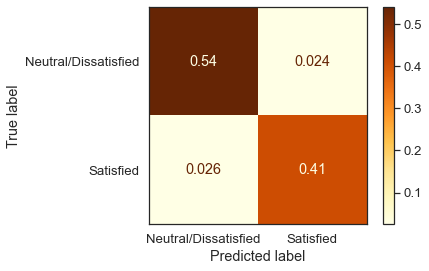

------------------ Mean Results --------------------
Mean precision: 0.9489268738515673
---
Mean recall: 0.9479083847792922
---
Mean f-scores: 0.948396962413804
---
Mean ROC_AUC: 0.9479083847792922


In [17]:
params_dt = {'criterion': 'gini',
             'max_depth': 20,
             'random_state':42}

precisions_dt = []
recalls_dt = []
f_scores_dt = []
supports_dt = []
rocs_auc_dt = []
index = 0

for train_index, test_index in skf.split(X,y):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    index+=1

    print(f"------------------ Results {index} fold --------------------")
    model_dt = DecisionTreeClassifier(**params_dt)
    model_dt, roc_auc_dt,report_dt = run_model(model_dt, X_train, y_train, X_test, y_test)
    
    precision, recall, f_score, support = report_dt

    precisions_dt.append(precision)
    recalls_dt.append(recall)
    f_scores_dt.append(f_score)
    supports_dt.append(support)
    rocs_auc_dt.append(roc_auc_dt)
    
print("------------------ Mean Results --------------------")
print(f"Mean precision: {np.mean((precisions_dt))}\n---")
print(f"Mean recall: {np.mean((recalls_dt))}\n---")
print(f"Mean f-scores: {np.mean((f_scores_dt))}\n---")
print(f"Mean ROC_AUC: {np.mean((rocs_auc_dt))}")

### Random Forest

------------------ Results 1 fold --------------------
ROC_AUC = 0.961116606405919
                      precision    recall  f1-score   support

Neutral/Dissatisfied    0.95737   0.97897   0.96805     18307
           Satisfied    0.97180   0.94326   0.95732     14065

            accuracy                        0.96346     32372
           macro avg    0.96459   0.96112   0.96268     32372
        weighted avg    0.96364   0.96346   0.96339     32372



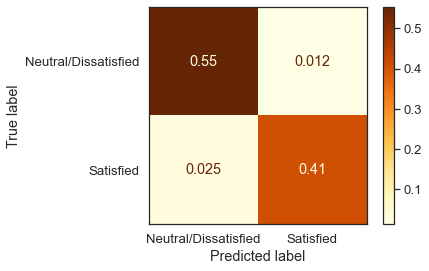

------------------ Results 2 fold --------------------
ROC_AUC = 0.9600040771721097
                      precision    recall  f1-score   support

Neutral/Dissatisfied    0.95445   0.98094   0.96751     18306
           Satisfied    0.97426   0.93907   0.95634     14066

            accuracy                        0.96275     32372
           macro avg    0.96435   0.96000   0.96193     32372
        weighted avg    0.96306   0.96275   0.96266     32372



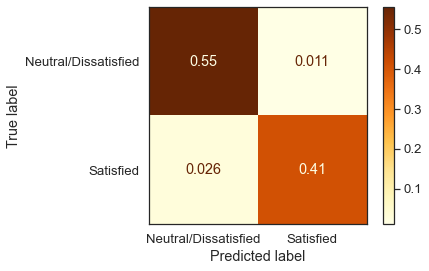

------------------ Results 3 fold --------------------
ROC_AUC = 0.9586279500292118
                      precision    recall  f1-score   support

Neutral/Dissatisfied    0.95490   0.97733   0.96598     18306
           Satisfied    0.96957   0.93993   0.95452     14066

            accuracy                        0.96108     32372
           macro avg    0.96223   0.95863   0.96025     32372
        weighted avg    0.96127   0.96108   0.96100     32372



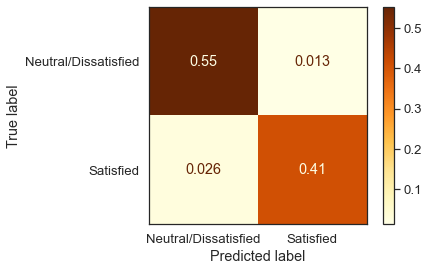

------------------ Results 4 fold --------------------
ROC_AUC = 0.9603478142968206
                      precision    recall  f1-score   support

Neutral/Dissatisfied    0.95649   0.97864   0.96744     18306
           Satisfied    0.97134   0.94205   0.95647     14065

            accuracy                        0.96274     32371
           macro avg    0.96391   0.96035   0.96195     32371
        weighted avg    0.96294   0.96274   0.96267     32371



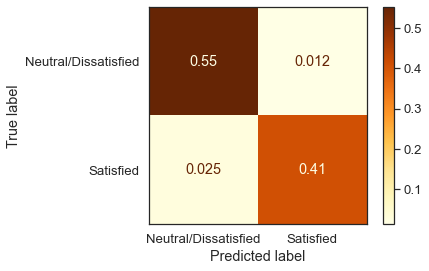

------------------ Mean Results --------------------
Mean precision : 0.9637708998485783
---
Mean recall: 0.9600241119760153
---
Mean f-scores: 0.9617038912267329
---
Mean ROC_AUC: 0.9600241119760152


In [18]:
params_rf = {'max_depth': 25,
         'min_samples_leaf': 1,
         'min_samples_split': 2,
         'n_estimators': 1200,
         'random_state': 42}

precisions_rf = []
recalls_rf = []
f_scores_rf = []
supports_rf = []
rocs_auc_rf =[]
index = 0

for train_index, test_index in skf.split(X,y):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    index+=1

    print(f"------------------ Results {index} fold --------------------")

    model_rf = RandomForestClassifier(**params_rf)
    model_rf, roc_auc_rf, report_rf = run_model(model_rf, X_train, y_train, X_test, y_test)
    
    precision, recall, f_score, support = report_rf
    precisions_rf.append(precision)
    recalls_rf.append(recall)
    f_scores_rf.append(f_score)
    supports_rf.append(support)
    rocs_auc_rf.append(roc_auc_rf)
    
print("------------------ Mean Results --------------------")
print(f"Mean precision : {np.mean((precisions_rf))}\n---")
print(f"Mean recall: {np.mean((recalls_rf))}\n---")
print(f"Mean f-scores: {np.mean((f_scores_rf))}\n---")
print(f"Mean ROC_AUC: {np.mean((rocs_auc_rf))}")

## Model Comparison and Conclusions

Based on the metrics obtained, it can be stated that the Random forest classifier outperformed all of the other models.

In [24]:
models = {'Gaussian NB':'gnb','KNN': 'knn','Decision Trees':'dt','Random Forest':'rf'}
model_list = []

for model,model_abv in models.items():
    model_dic = {'Model': model,'AUC':np.mean(eval('rocs_auc_{0}'.format(model_abv))),
     'Precision':np.mean(eval('precisions_{0}'.format(model_abv))),
     'Recall':np.mean(eval('recalls_{0}'.format(model_abv))),
     'F-score': np.mean(eval('f_scores_{0}'.format(model_abv))) }
    model_list.append(model_dic)


In [25]:
model_df = pd.DataFrame(model_list)
model_df

,Model,AUC,Precision,Recall,F-score
0,Gaussian NB,0.859171,0.863616,0.859171,0.861030
1,KNN,0.921174,0.928419,0.921174,0.924104
2,Decision Trees,0.947908,0.948927,0.947908,0.948397
3,Random Forest,0.960024,0.963771,0.960024,0.961704


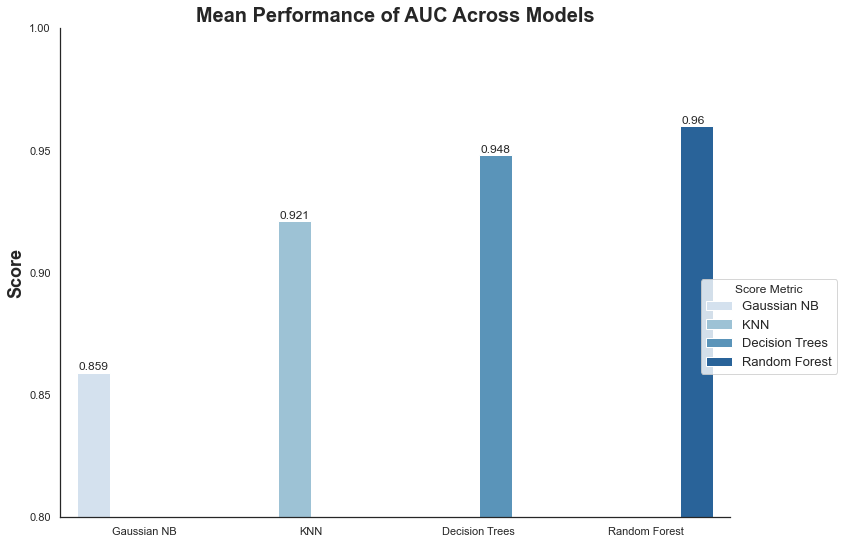

In [21]:
sns.set(style='white',font_scale=1)
fig = plt.figure(figsize=[12,9])
ax = sns.barplot(x='Model',y='AUC',data=model_df,hue='Model',palette='Blues')
for p in ax.patches:
        ax.annotate(p.get_height().round(3), (p.get_x()+0.01, p.get_height()+0.001))
plt.legend(title='Score Metric',loc="upper right", bbox_to_anchor=(1.17, 0.5),fontsize=13)
plt.ylim([0.8,1.0])
plt.yticks([0.80,0.85,0.90,0.95,1.00])
plt.xlabel('',weight='bold',fontsize='15')
plt.ylabel('Score',weight='bold',fontsize='18')
plt.title('Mean Performance of AUC Across Models',weight='bold',fontsize=20)
sns.despine()

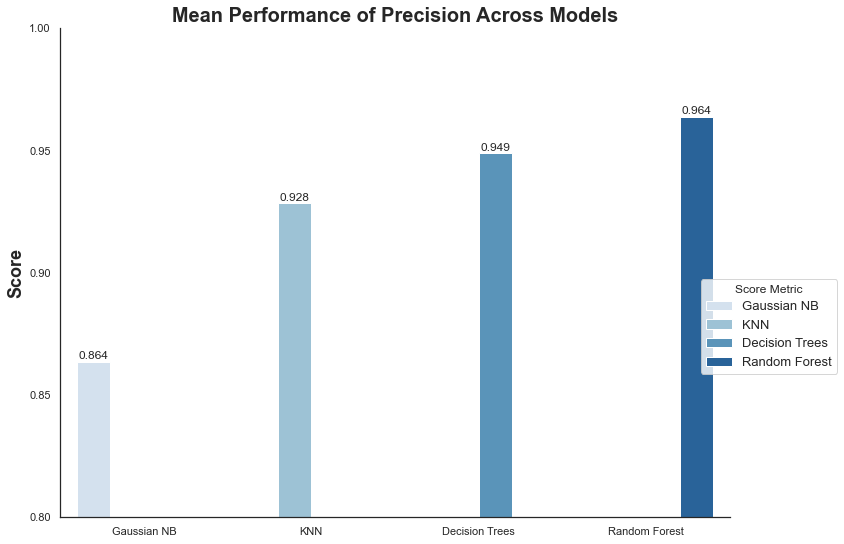

In [22]:
sns.set(style='white',font_scale=1)
fig = plt.figure(figsize=[12,9])
ax = sns.barplot(x='Model',y='Precision',data=model_df,hue='Model',palette='Blues')
for p in ax.patches:
        ax.annotate(p.get_height().round(3), (p.get_x()+0.01, p.get_height()+0.001))
plt.legend(title='Score Metric',loc="upper right", bbox_to_anchor=(1.17, 0.5),fontsize=13)
plt.ylim([0.8,1.0])
plt.yticks([0.80,0.85,0.90,0.95,1.00])
plt.xlabel('',weight='bold',fontsize='15')
plt.ylabel('Score',weight='bold',fontsize='18')
plt.title('Mean Performance of Precision Across Models',weight='bold',fontsize=20)
sns.despine()

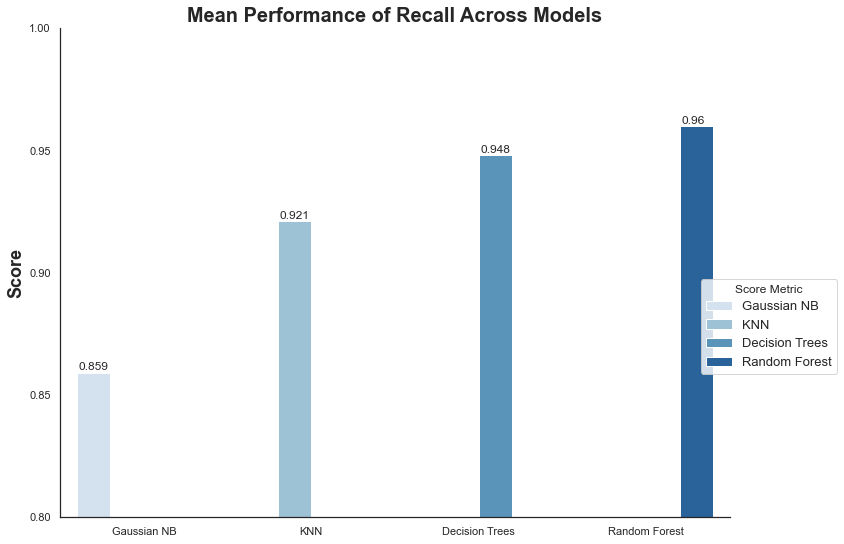

In [26]:
sns.set(style='white',font_scale=1)
fig = plt.figure(figsize=[12,9])
ax = sns.barplot(x='Model',y='Recall',data=model_df,hue='Model',palette='Blues')
for p in ax.patches:
        ax.annotate(p.get_height().round(3), (p.get_x()+0.01, p.get_height()+0.001))
plt.legend(title='Score Metric',loc="upper right", bbox_to_anchor=(1.17, 0.5),fontsize=13)
plt.ylim([0.8,1.0])
plt.yticks([0.80,0.85,0.90,0.95,1.00])
plt.xlabel('',weight='bold',fontsize='15')
plt.ylabel('Score',weight='bold',fontsize='18')
plt.title('Mean Performance of Recall Across Models',weight='bold',fontsize=20)
sns.despine()

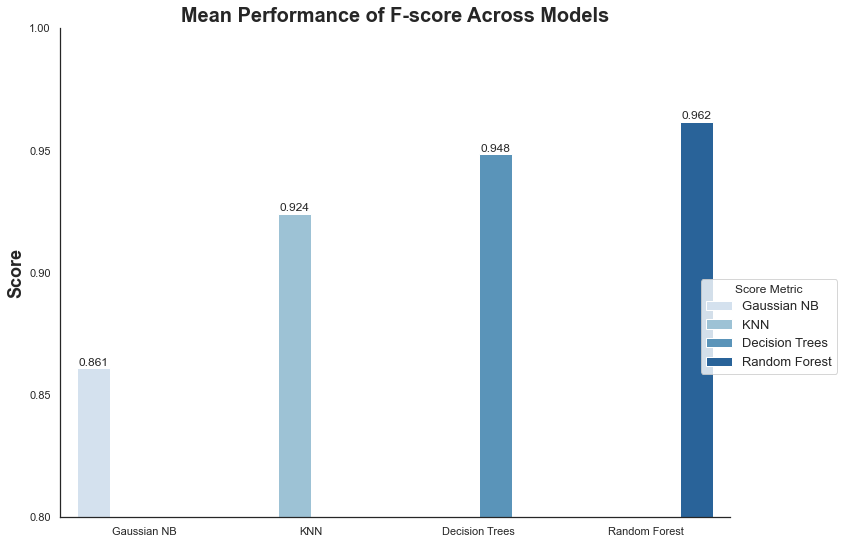

In [27]:
sns.set(style='white',font_scale=1)
fig = plt.figure(figsize=[12,9])
ax = sns.barplot(x='Model',y='F-score',data=model_df,hue='Model',palette='Blues')
for p in ax.patches:
        ax.annotate(p.get_height().round(3), (p.get_x()+0.01, p.get_height()+0.001))
plt.legend(title='Score Metric',loc="upper right", bbox_to_anchor=(1.17, 0.5),fontsize=13)
plt.ylim([0.8,1.0])
plt.yticks([0.80,0.85,0.90,0.95,1.00])
plt.xlabel('',weight='bold',fontsize='15')
plt.ylabel('Score',weight='bold',fontsize='18')
plt.title('Mean Performance of F-score Across Models',weight='bold',fontsize=20)
sns.despine()